# Time Series Forecast - Police Stops

## Libraries

In [20]:
import sagemaker
import boto3
from datetime import datetime
from io import StringIO
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff

In [7]:
%store -r diff_ripa
%store -r ripa_stops_df_cleaned
%store -r ripa_stops_ts 

%store -r ripa_stops_log 
%store -r decom_ripa 
%store -r trend_ripa_stops 
%store -r season_ripa_stops 
%store -r resid_ripa_stops 



# Autocorrelation Function and Partial Autocorrelation Function

In [15]:
acf_ripa_stops = acf(diff_ripa, nlags=20, fft=False)
pacf_ripa_stops = pacf(diff_ripa, nlags=20, method='ols')

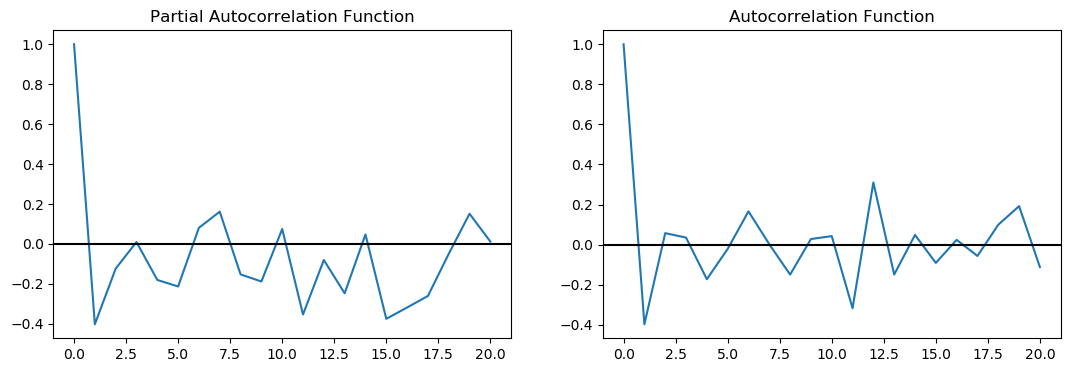

In [18]:
# Plotting PACF

f = plt.figure()
f.set_figwidth(13)
f.set_figheight(4)




plt.subplot(121)
plt.plot(pacf_ripa_stops)
plt.axhline(y=0, color="black")
plt.title("Partial Autocorrelation Function")

# Plotting ACF

plt.subplot(122)
plt.plot(acf_ripa_stops)
plt.axhline(y=0, color="black")
plt.title("Autocorrelation Function")

plt.show()

# Split Dataset for Training, Testing, and Validation

In [38]:
# training 80%, testing 10%, validation 10%

total = len(ripa_stops_df_cleaned)
print("Total Amount: ", total)

# training set
ripa_stops_train = ripa_stops_df_cleaned[  :int(len(ripa_stops_df_cleaned)*0.8)]

# validation and testing set
ripa_stops_holdout = ripa_stops_df_cleaned[  int(len(ripa_stops_df_cleaned)*0.8) : ]

ripa_stops_valid = ripa_stops_holdout[ : int(len(ripa_stops_df_cleaned)*0.2)  ]
ripa_stops_test = ripa_stops_holdout[ : int(len(ripa_stops_df_cleaned)*0.2)  ]


print("ripa_training_set: ", ripa_stops_train.shape)
print("ripa_validation_set: ", ripa_stops_valid.shape)
print("ripa_testing_set: ", ripa_stops_test.shape)

Total Amount:  650870
ripa_training_set:  (520696, 11)
ripa_validation_set:  (130174, 11)
ripa_testing_set:  (130174, 11)


## ARIMA Model

In [ ]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)

arima_model = ARIMA(ripa_stops_log, order = (2,1,2))
arima_output = arima_model.fit(disp=-1)
plt.plot(diff_ripa)
plt.plot(arima_output.fittedvalues, color="orange", label = "ARIMA Results")
plt.legend()
plt.title("ARIMA Model Results")
plt.show()


## AR Model

In [ ]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)

ar_model = ARIMA(ripa_stops_log, order = (2,1,0))
ar_output = ar_model.fit(disp=-1)
plt.plot(diff_ripa)
plt.plot(ar_output.fittedvalues, color="red", label = "AR Results")
plt.legend()
plt.title("AR Model Results")
plt.show()

## MA Model

In [ ]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)
 
ma_model = ARIMA(ripa_stops_log, order = (0,1,2))
ma_output = ma_model.fit(disp=-1)
plt.plot(diff_ripa)
plt.plot(ma_output.fittedvalues, color="green", label = "MA Results")
plt.legend()
plt.title("MA Model Results")
plt.show()

# RSS Values of ARIMA Models

In [ ]:
# RSS Values

print("RSS Values")
print("ARIMA Model:",  sum( (arima_output.fittedvalues - diff_ripa)**2))
print("AR Model:",  sum( (ar_output.fittedvalues - diff_ripa)**2))
print("MA Model:",  sum( (ma_output.fittedvalues - diff_ripa)**2))

# RMSE Values of ARIMA Models

In [ ]:
 # RMSE Values  